# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = '../data/' #You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

# Your code goes here

## Task 0: Research Question

**Research question:**
*How can we mesure the retention of pubils on the platform?*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

### 📊 Data-pre-processing pipeline

1. **Timestamp → calendar week**  
   * Parse `events.event_date` and `transactions.start_time` into a proper `datetime`.  
   * Derive **`year_week`** using `strftime('%Y-%U')` (Sunday-based week index, `00-53`).

2. **Weekly behavioural features** – computed per **`(user_id, year_week)`**

   | Dimension | Features |
   |-----------|----------|
   | **Effort** | `weekly_events`, `weekly_clicks`, `weekly_time_spent` |
   | **Consistency** | `mean_session_duration`, `std_weekly_activity` |
   | **Regularity** | `mean_days_between_sessions` |
   | **Proactivity** | `weekly_go_to_theory`, `weekly_early_sessions` |
   | **Control** | `weekly_next_actions`, `weekly_skip_actions` |
   | **Assessment** | `weekly_percentage_correct`, `weekly_challenges_completed` |

3. **Build `user_week_features`**  
   * Start from the unique `(user_id, year_week)` pairs in `events`.  
   * Left-join every feature dataframe above.  
   * Replace `NaN` with **0** (means “no activity that week”).  
   * Append per-user `std_weekly_activity`.

4. **Prune inactive learners**  
   * Compute per-user totals:  
     * `n_events` = all events  
     * `n_weeks`  = weeks with ≥1 event  
   * Keep users with **≥ 10 events AND ≥ 10 active weeks**.  
   * Re-filter `events`, `transactions`, `user_week_features`.

5. **Create engagement label `engaged_next_week`**  
   * “Meaningful” actions: `SUBMIT_ANSWER`, `REVIEW_TASK`, `NEXT`, `SKIP`, `GO_TO_THEORY`.  
   * For each week *t*: **1** if the same learner performs ≥ 1 meaningful action in week *t + 1*; else **0**.  
   * Merge the label into `user_week_features`.

6. **QA visual checks**  
   * Histograms / KDE for every numeric feature (seaborn).  
   * Weekly engagement-rate line chart to spot seasonal dips or spikes.

Result ⇒ **`user_week_features`**: one row per learner-week, ~25 engineered numeric features, plus the binary target **`engaged_next_week`** – ready for clustering & modelling.

is_active
False    20557
True      1913
Name: count, dtype: int64


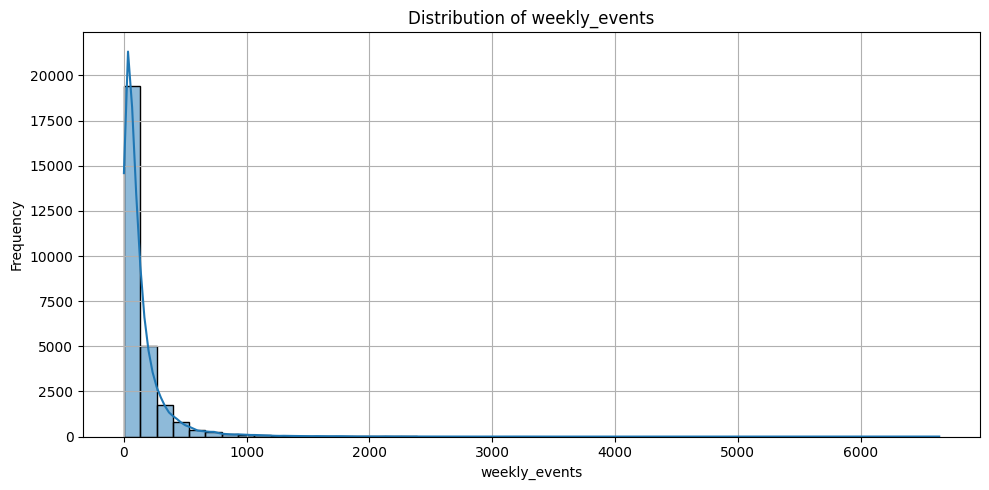

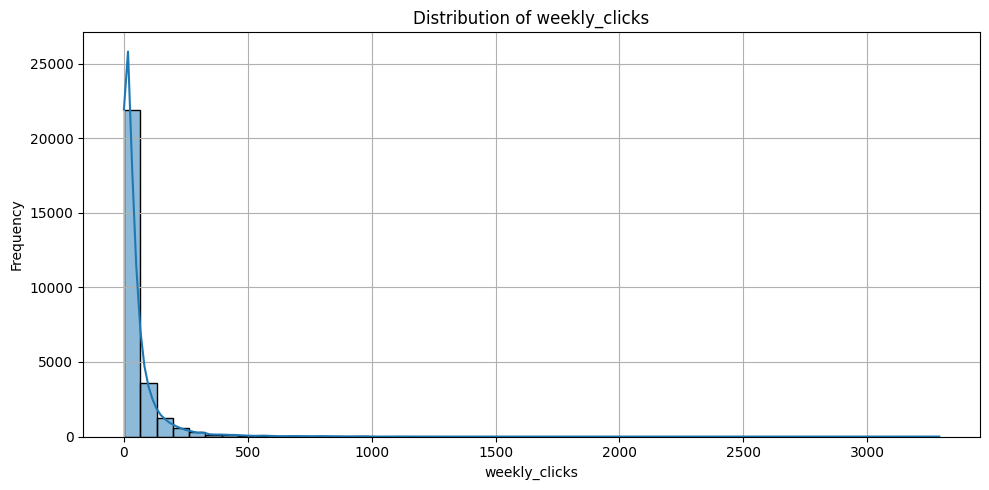

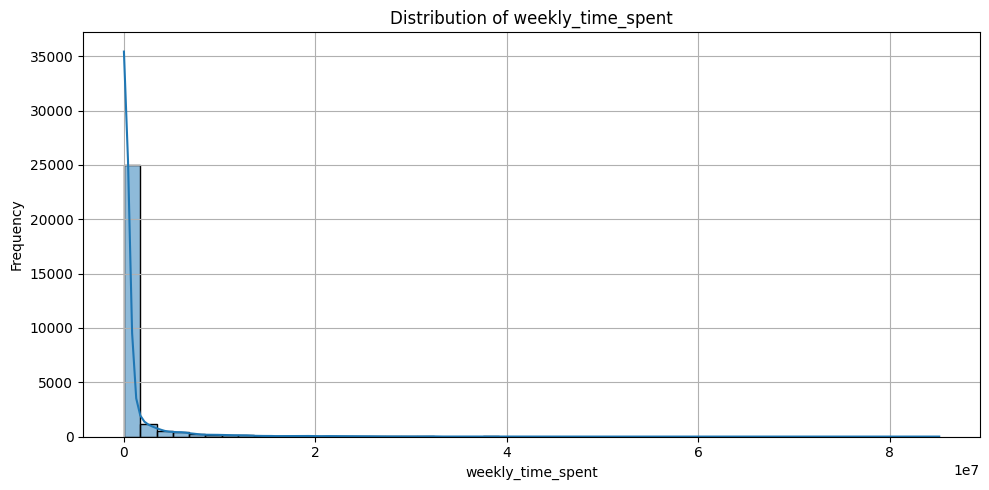

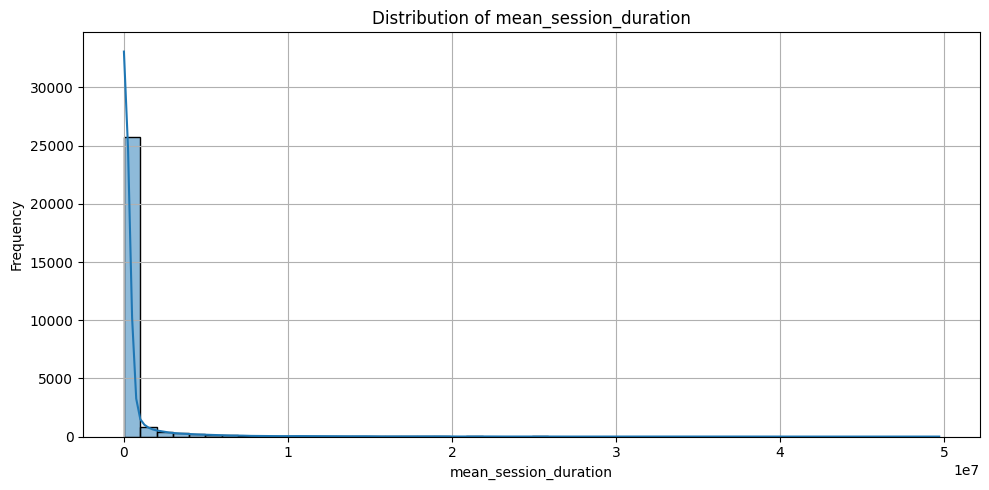

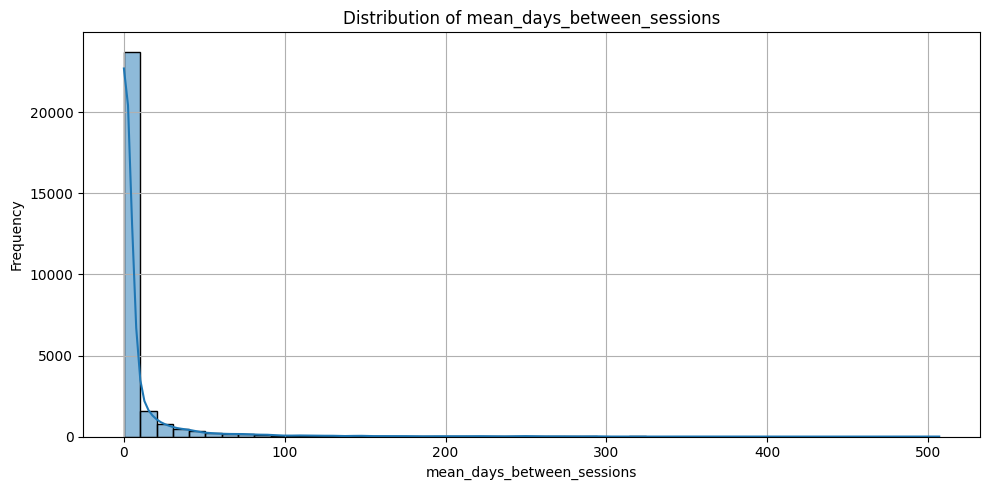

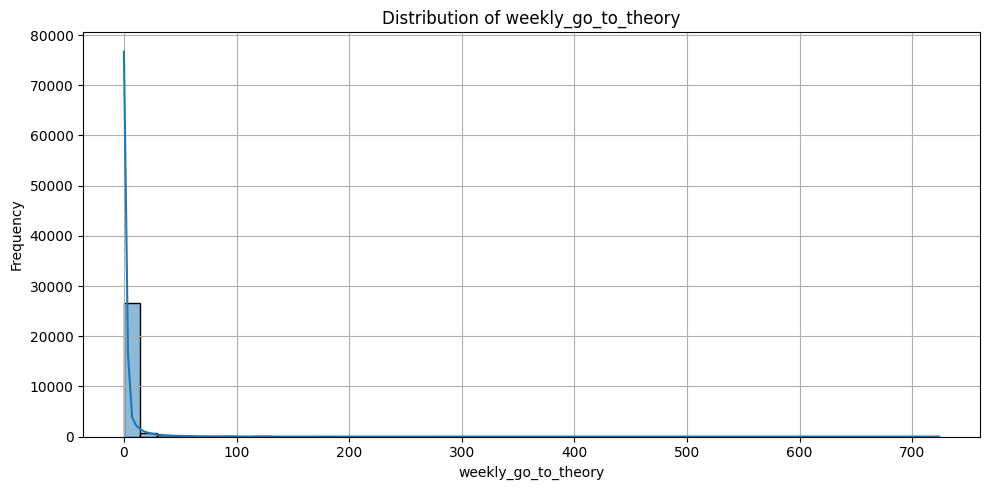

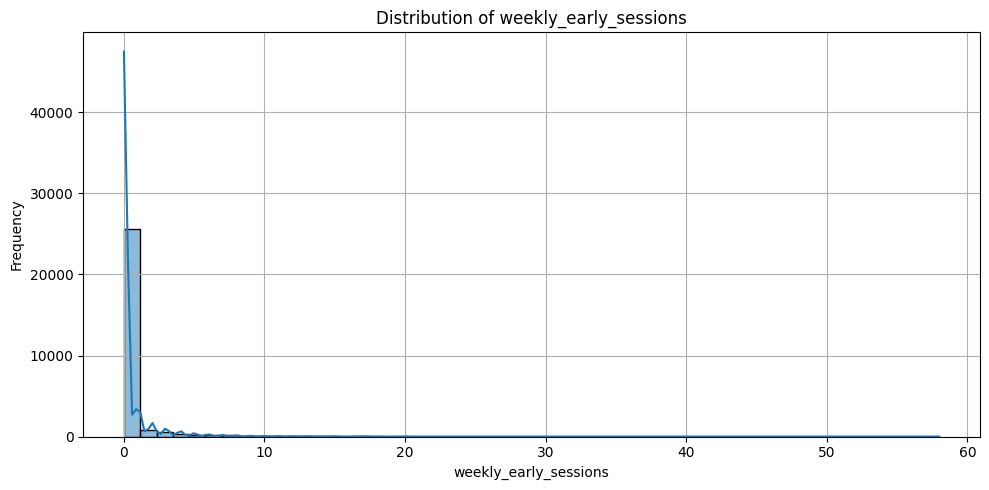

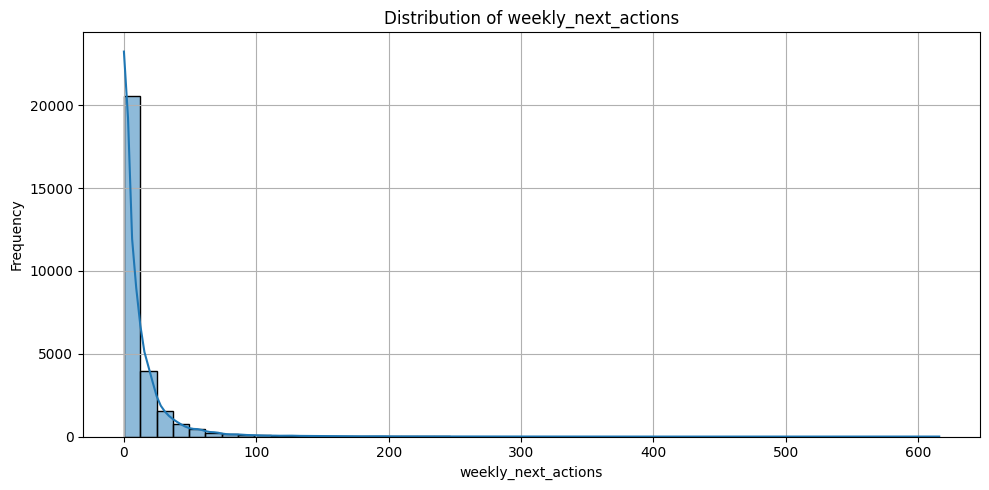

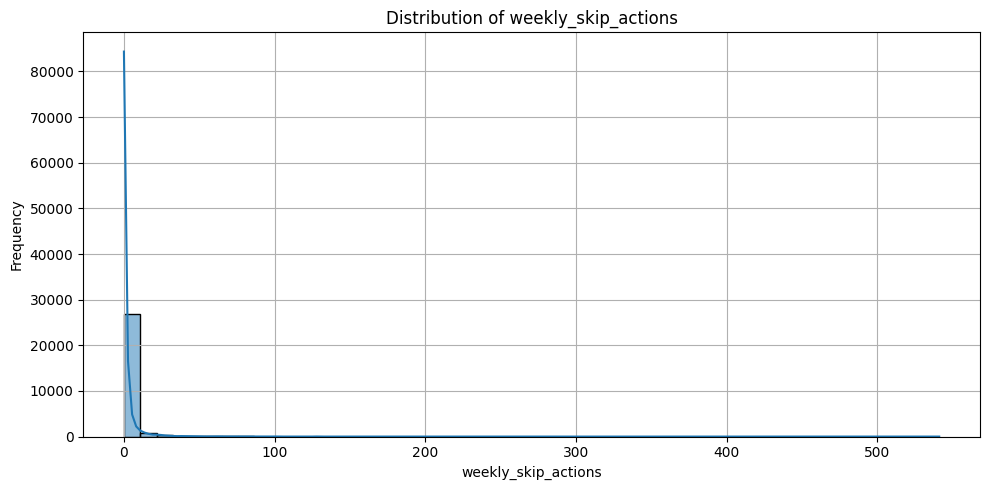

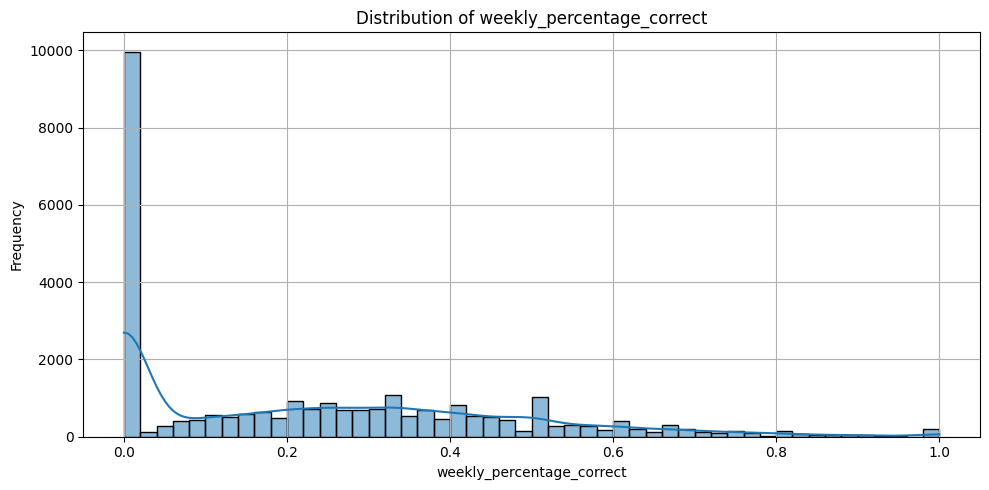

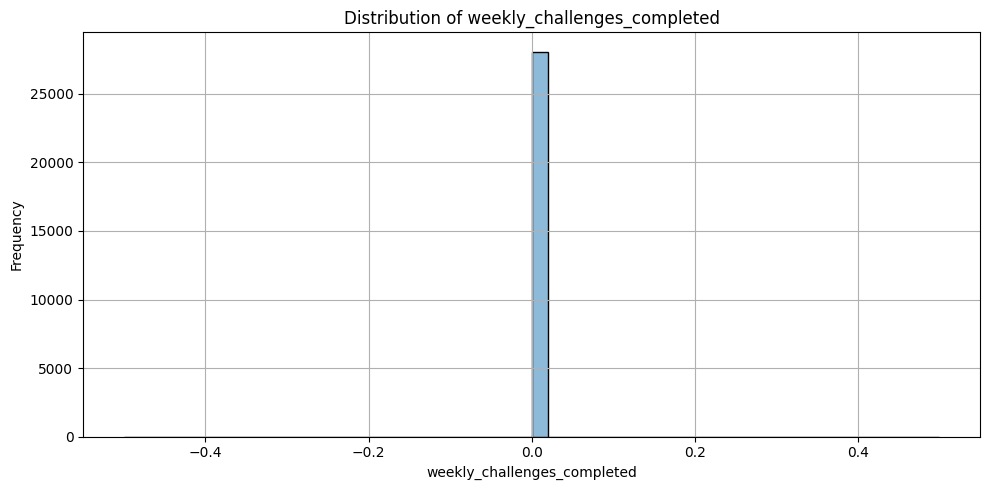

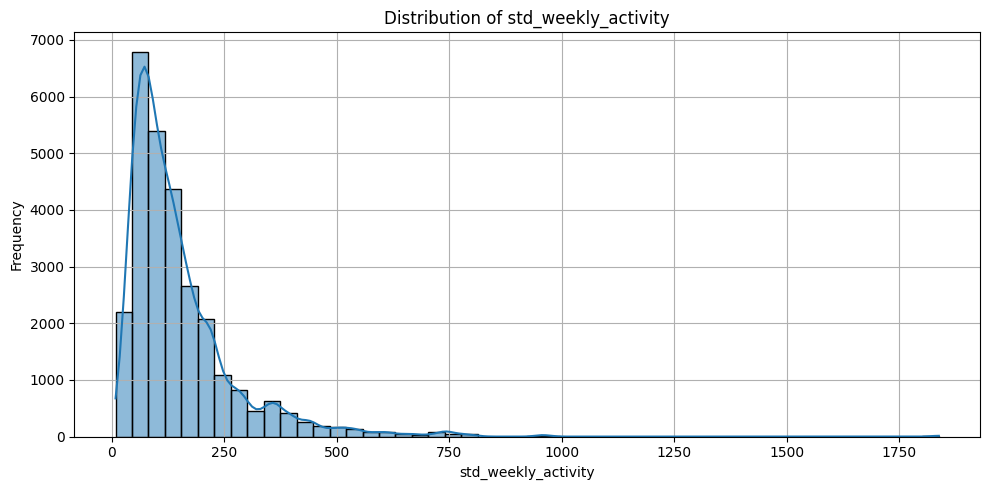

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert event_date and start_time to datetime
events['date'] = pd.to_datetime(events['event_date'])
transactions['date'] = pd.to_datetime(transactions['start_time'])

# Extract year and week number
events['year_week'] = events['date'].dt.strftime('%Y-%U')
transactions['year_week'] = transactions['date'].dt.strftime('%Y-%U')

# Effort
weekly_events = events.groupby(['user_id', 'year_week']).size().reset_index(name='weekly_events')
weekly_clicks = events[events['event_type'] == 'CLICK'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_clicks')

# Time spent per session
events = events.sort_values(by=['user_id', 'date'])
events['next_date'] = events.groupby(['user_id', 'session_id'])['date'].shift(-1)
events['session_time'] = (events['next_date'] - events['date']).dt.total_seconds()
weekly_time_spent = events.groupby(['user_id', 'year_week'])['session_time'].sum().reset_index(name='weekly_time_spent')

# Consistency
session_durations = events.groupby(['user_id', 'session_id']).agg(
    session_start=('date', 'min'),
    session_end=('date', 'max')
).reset_index()
session_durations['duration'] = (session_durations['session_end'] - session_durations['session_start']).dt.total_seconds()
session_durations['year_week'] = session_durations['session_start'].dt.strftime('%Y-%U')
mean_session_duration = session_durations.groupby(['user_id', 'year_week'])['duration'].mean().reset_index(name='mean_session_duration')

std_weekly_activity = weekly_events.groupby('user_id')['weekly_events'].std().reset_index(name='std_weekly_activity')

# Regularity
session_starts = events.groupby(['user_id', 'session_id'])['date'].min().reset_index()
session_starts = session_starts.sort_values(by=['user_id', 'date'])
session_starts['previous_session'] = session_starts.groupby('user_id')['date'].shift(1)
session_starts['days_between'] = (session_starts['date'] - session_starts['previous_session']).dt.days
session_starts['year_week'] = session_starts['date'].dt.strftime('%Y-%U')
mean_days_between_sessions = session_starts.groupby(['user_id', 'year_week'])['days_between'].mean().reset_index(name='mean_days_between_sessions')

# Proactivity
go_to_theory_actions = events[events['action'] == 'GO_TO_THEORY'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_go_to_theory')
events['hour'] = events['date'].dt.hour
early_sessions = events[events['hour'] < 8].groupby(['user_id', 'year_week'])['session_id'].nunique().reset_index(name='weekly_early_sessions')

# Control
next_actions = events[events['action'] == 'NEXT'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_next_actions')
skip_actions = events[events['action'] == 'SKIP'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_skip_actions')

# Assessment
correct_evaluations = transactions[transactions['evaluation'] == 'CORRECT'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_correct')
total_evaluations = transactions.groupby(['user_id', 'year_week']).size().reset_index(name='weekly_total')
assessment = pd.merge(total_evaluations, correct_evaluations, on=['user_id', 'year_week'], how='left').fillna(0)
assessment['weekly_percentage_correct'] = assessment['weekly_correct'] / assessment['weekly_total']

challenges_completed = transactions[transactions['challenge_id'].notnull() & (transactions['session_accepted'] == 1)].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_challenges_completed')

# Combine all features
user_week_features = pd.DataFrame(events[['user_id', 'year_week']].drop_duplicates())

feature_dfs = [
    weekly_events, weekly_clicks, weekly_time_spent, mean_session_duration,
    mean_days_between_sessions, go_to_theory_actions,
    early_sessions, next_actions, skip_actions,
    assessment[['user_id', 'year_week', 'weekly_percentage_correct']], challenges_completed
]

for feature_df in feature_dfs:
    user_week_features = pd.merge(user_week_features, feature_df, on=['user_id', 'year_week'], how='left')

# Fill missing values with 0
user_week_features = user_week_features.fillna(0)

user_week_features = pd.merge(user_week_features, std_weekly_activity, on='user_id', how='left')


# -------------------------------------------------------------------
# 1.  total events per user
total_events = events.groupby('user_id').size().rename('n_events')

# 2.  active weeks per user  (we already have weekly_events)
active_weeks = weekly_events.groupby('user_id').size().rename('n_weeks')

# 3.  merge the two summaries
activity_summary = pd.concat([total_events, active_weeks], axis=1).fillna(0)

# 4.  flag "active" learners
activity_summary['is_active'] = (
        (activity_summary['n_events'] >= 10) &
        (activity_summary['n_weeks']  >= 10)
)

print(activity_summary['is_active'].value_counts())

# 1.  keep only active user_ids
active_ids = activity_summary.index[activity_summary['is_active']]

events        = events[events['user_id'].isin(active_ids)]
transactions  = transactions[transactions['user_id'].isin(active_ids)]

# 2.  because user_week_features is built *after* events filtering,
#     you can now rerun the feature-engineering cell OR
#     just filter the existing DF:
user_week_features = user_week_features[user_week_features['user_id'].isin(active_ids)]

# Visualize the features
numeric_cols = user_week_features.select_dtypes(include=['number']).columns.drop('user_id', errors='ignore')

for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(user_week_features[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Create correlation matrix to visualize relationships between features    #



In [3]:
user_week_features.to_csv("../data/user_week_features.csv", index=False)

user_week_features.head(   )

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,weekly_skip_actions,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity
0,387604,2021-20,1,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
1,387604,2021-21,1,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
2,387604,2021-25,7,4.0,7.837221e+05,7.837424e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
3,387604,2021-26,25,12.0,1.047106e+07,2.957527e+07,9.0,0.0,0.0,0.0,7.0,0.0,0.0,141.95107
4,387604,2021-31,12,6.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107


In [4]:
# A user is said active if he has in every engagement part of our score weekly_events > 0 & weekly_time_spent > 0 & weekly_clicks > 0
# else we cannot say he was active in that week 

print(user_week_features[user_week_features['weekly_events'] > 3].head())

print(user_week_features[user_week_features['weekly_events'] > 0]["weekly_events"].describe())
print(user_week_features[user_week_features['weekly_time_spent'] > 0]["weekly_events"].describe())
print(user_week_features[user_week_features['weekly_clicks'] > 0]["weekly_clicks"].describe())

user_week_features[
    (user_week_features['weekly_clicks'] > 0) &
    (user_week_features['weekly_time_spent'] > 0) &
    (user_week_features['weekly_events'] > 0)
].head()


   user_id year_week  weekly_events  weekly_clicks  weekly_time_spent  \
2   387604   2021-25              7            4.0       7.837221e+05   
3   387604   2021-26             25           12.0       1.047106e+07   
4   387604   2021-31             12            6.0       0.000000e+00   
5   387604   2021-32             12            3.0       0.000000e+00   
6   387604   2021-33             93           23.0       3.437000e+00   

   mean_session_duration  mean_days_between_sessions  weekly_go_to_theory  \
2           7.837424e+05                         0.0                  0.0   
3           2.957527e+07                         9.0                  0.0   
4           0.000000e+00                         0.0                  0.0   
5           0.000000e+00                        41.0                  0.0   
6           3.437000e+00                         6.0                 18.0   

   weekly_early_sessions  weekly_next_actions  weekly_skip_actions  \
2                    0.0    

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,weekly_skip_actions,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity
2,387604,2021-25,7,4.0,7.837221e+05,7.837424e+05,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
3,387604,2021-26,25,12.0,1.047106e+07,2.957527e+07,9.000000,0.0,0.0,0.0,7.0,0.0,0.0,141.95107
6,387604,2021-33,93,23.0,3.437000e+00,3.437000e+00,6.000000,18.0,1.0,0.0,0.0,0.0,0.0,141.95107
8,387604,2021-35,405,111.0,8.352444e+04,6.424957e+03,0.846154,118.0,3.0,0.0,12.0,0.0,0.0,141.95107
9,387604,2021-36,139,39.0,6.595295e+04,1.648824e+04,2.000000,27.0,1.0,0.0,0.0,0.0,0.0,141.95107


In [5]:
# ADD missing weeks

# Convert 'year_week' to datetime-compatible period
user_week_features['year_week'] = pd.to_datetime(user_week_features['year_week'] + '-1', format='%Y-%W-%w')

# Create full user-week grid
all_users = user_week_features['user_id'].unique()
all_weeks = pd.date_range(
    start=user_week_features['year_week'].min(),
    end=user_week_features['year_week'].max(),
    freq='W-MON'
)
user_week_grid = pd.MultiIndex.from_product(
    [all_users, all_weeks], names=["user_id", "year_week"]
).to_frame(index=False)

# Merge with original data
merged = pd.merge(user_week_grid, user_week_features, on=['user_id', 'year_week'], how='left')

# Fill NaNs for features with 0, except 'user_id' and 'year_week'
feature_cols = [col for col in user_week_features.columns if col not in ['user_id', 'year_week']]
merged[feature_cols] = merged[feature_cols].fillna(0)

# Reconvert 'year_week' to the original format if needed
merged['year_week'] = merged['year_week'].dt.strftime('%Y-%W')

merged.head()
#df_combined.head()

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,weekly_skip_actions,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity
0,387604,2021-20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
1,387604,2021-21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
2,387604,2021-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,387604,2021-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,387604,2021-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


/var/folders/0k/43ckgrhd7cd68vbpqrmw9r240000gn/T/ipykernel_1063/1355576066.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(['Still Active', 'Churned'])


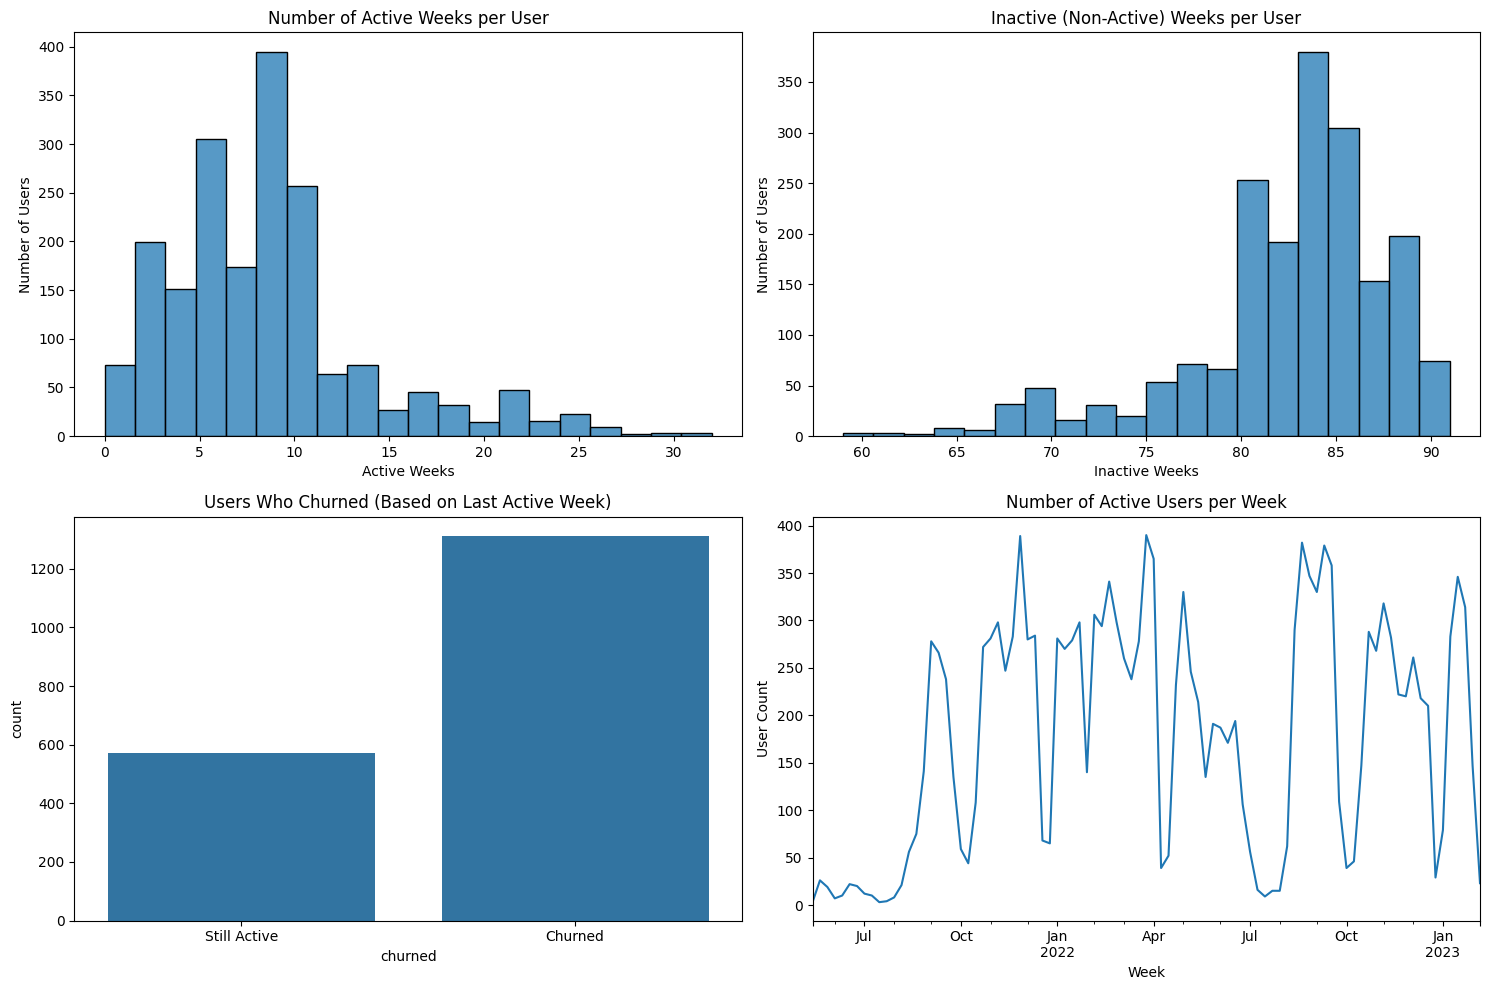

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,weekly_skip_actions,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity,week_start,active_week,next_week_active,week_diff,missing_active_weeks
0,387604,2021-20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107,2021-05-17,0,0,NaN,True
1,387604,2021-21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107,2021-05-24,0,0,7.0,True
2,387604,2021-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,2021-05-31,0,0,7.0,True
3,387604,2021-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,2021-06-07,0,0,7.0,True
4,387604,2021-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,2021-06-14,0,1,7.0,True


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a working copy
df_full = merged.copy()

# Convert to week_start for time-based operations
df_full['week_start'] = pd.to_datetime(df_full['year_week'] + '-1', format='%Y-%W-%w')

# Define active week condition
df_full['active_week'] = (
    (df_full['weekly_clicks'] > 0) &
    (df_full['weekly_time_spent'] > 0) &
    (df_full['weekly_events'] > 0)
).astype(int)

# Sort for shifting
df_full = df_full.sort_values(by=['user_id', 'week_start'])

# Add label: was next week active?
df_full['next_week_active'] = df_full.groupby('user_id')['active_week'].shift(-1).fillna(0).astype(int)


# Assume df_full exists and has 'active_week' and 'week_start' columns
# Mark week differences per user
df_full = df_full.sort_values(by=['user_id', 'week_start'])
df_full['week_diff'] = df_full.groupby('user_id')['week_start'].diff().dt.days

# Count missing active weeks only (not just gaps)
df_full['missing_active_weeks'] = df_full['active_week'] == 0
user_gaps = df_full.groupby('user_id')['missing_active_weeks'].sum().reset_index()

# Determine churned users using active_week only
user_last_active = df_full[df_full['active_week'] == 1].groupby('user_id')['week_start'].max().reset_index()
last_week = df_full['week_start'].max()- pd.Timedelta(weeks=3)
user_last_active['churned'] = user_last_active['week_start'] < last_week
churned_users = user_last_active['churned'].sum()

# Plot preparation
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Number of active weeks per user
user_active_counts = df_full.groupby('user_id')['active_week'].sum()
sns.histplot(user_active_counts, bins=20, ax=axs[0, 0])
axs[0, 0].set_title("Number of Active Weeks per User")
axs[0, 0].set_xlabel("Active Weeks")
axs[0, 0].set_ylabel("Number of Users")

# Plot 2: Inactive weeks per user
sns.histplot(user_gaps['missing_active_weeks'], bins=20, ax=axs[0, 1])
axs[0, 1].set_title("Inactive (Non-Active) Weeks per User")
axs[0, 1].set_xlabel("Inactive Weeks")
axs[0, 1].set_ylabel("Number of Users")

# Plot 3: Users who churned based on active behavior
sns.countplot(x='churned', data=user_last_active, ax=axs[1, 0])
axs[1, 0].set_title("Users Who Churned (Based on Last Active Week)")
axs[1, 0].set_xticklabels(['Still Active', 'Churned'])

# Plot 4: Active users per week
weekly_active_user_counts = df_full[df_full['active_week'] == 1].groupby('week_start')['user_id'].nunique()
weekly_active_user_counts.plot(ax=axs[1, 1])
axs[1, 1].set_title("Number of Active Users per Week")
axs[1, 1].set_xlabel("Week")
axs[1, 1].set_ylabel("User Count")

plt.tight_layout()
plt.show()

df_full.head()

In [7]:
# Ensure week_start is datetime

# Find last week seen per user
# Get the last active week per user
last_active = (
    df_full[df_full['active_week'] == 1]
    .groupby('user_id')['week_start']
    .max()
    .reset_index()
    .rename(columns={'week_start': 'last_active_week'})
)

# Merge with main data
df_full = df_full.merge(last_active, on='user_id', how='left')

# Mark only if it's the last active week
df_full['is_last_week_ever'] = (df_full['week_start'] == df_full['last_active_week']).astype(int)

# Optional: clean up
df_full.drop(columns=['last_active_week'], inplace=True)

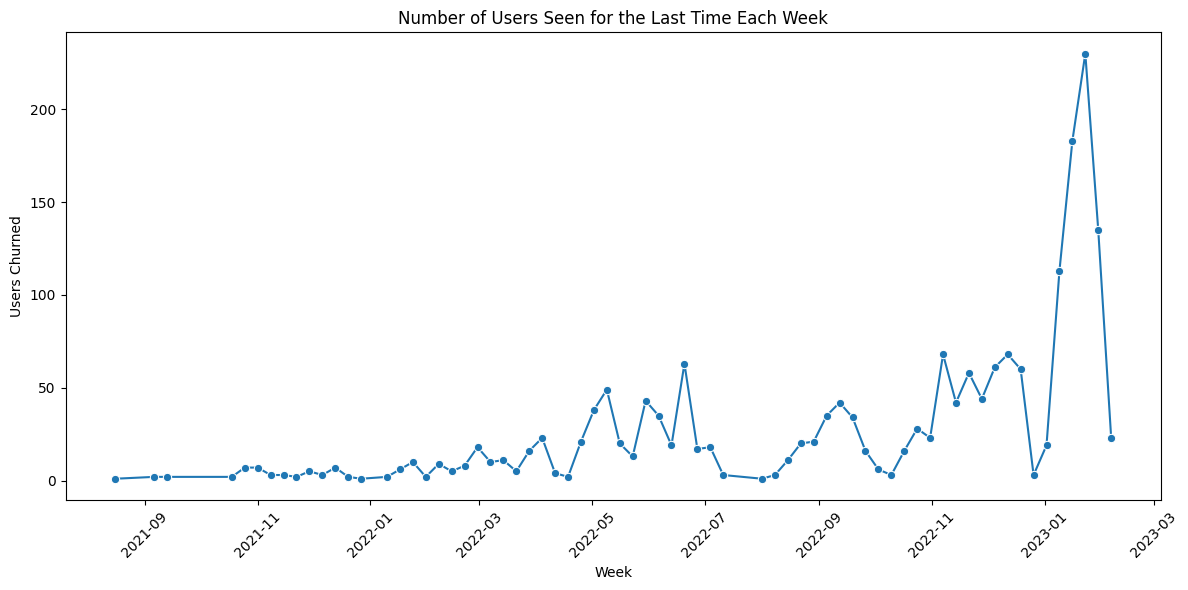

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate reloading df_full with 'is_last_week_ever' already computed
# In reality, you would use your real df_full with that column added

# Sample: Aggregate last seen info
df_plot = df_full[df_full['is_last_week_ever'] == 1]
weekly_churn_counts = df_plot.groupby('week_start')['user_id'].nunique().reset_index()
weekly_churn_counts.columns = ['week_start', 'num_users_last_seen']

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_churn_counts, x='week_start', y='num_users_last_seen', marker='o')
plt.title("Number of Users Seen for the Last Time Each Week")
plt.xlabel("Week")
plt.ylabel("Users Churned")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### reflections

it seems that holidays and the date fo the exams have a big impact on the engagement of the students. It seems to make sense the stop our data before the winter holiday in 2022 this is around the 10th of December. 


In [9]:
# Ensure datetime
df_full['week_start'] = pd.to_datetime(df_full['week_start'])

# Define cutoff date (Winter holiday 2022 start)
cutoff_date = pd.to_datetime("2022-12-10")

# Filter only rows before the cutoff
df_full = df_full[df_full['week_start'] < cutoff_date].copy()


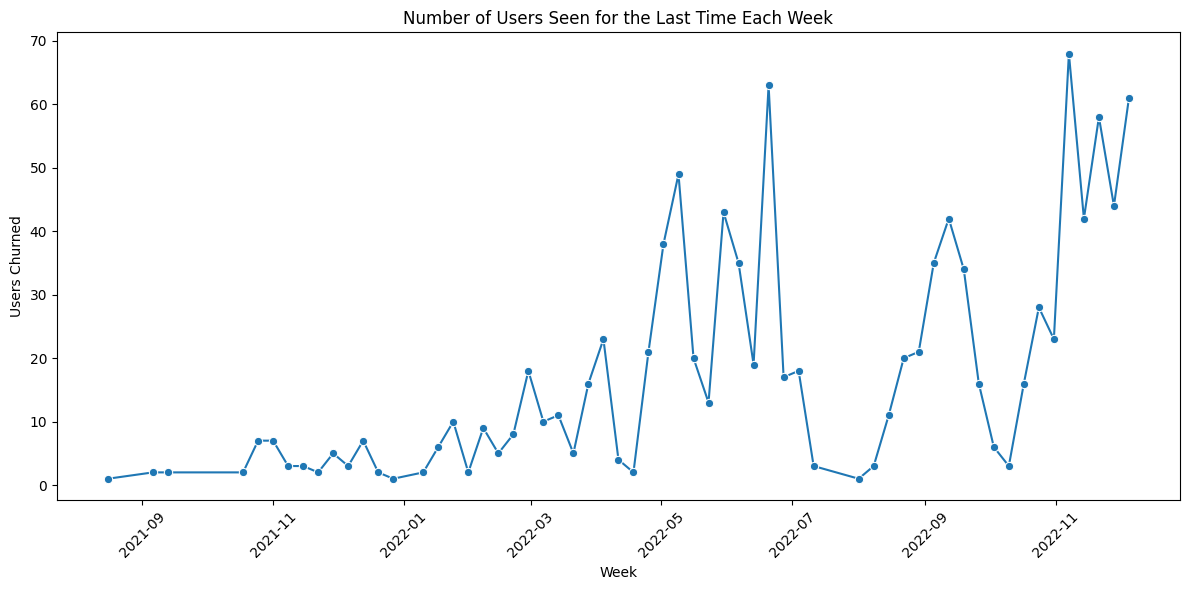

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate reloading df_full with 'is_last_week_ever' already computed
# In reality, you would use your real df_full with that column added

# Sample: Aggregate last seen info
df_plot = df_full[df_full['is_last_week_ever'] == 1]
weekly_churn_counts = df_plot.groupby('week_start')['user_id'].nunique().reset_index()
weekly_churn_counts.columns = ['week_start', 'num_users_last_seen']

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_churn_counts, x='week_start', y='num_users_last_seen', marker='o')
plt.title("Number of Users Seen for the Last Time Each Week")
plt.xlabel("Week")
plt.ylabel("Users Churned")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Now at the end its not the biggest spike anymore with makes our data more homogeneous.

/var/folders/0k/43ckgrhd7cd68vbpqrmw9r240000gn/T/ipykernel_1063/3105045957.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(['Still Active', 'Churned'])


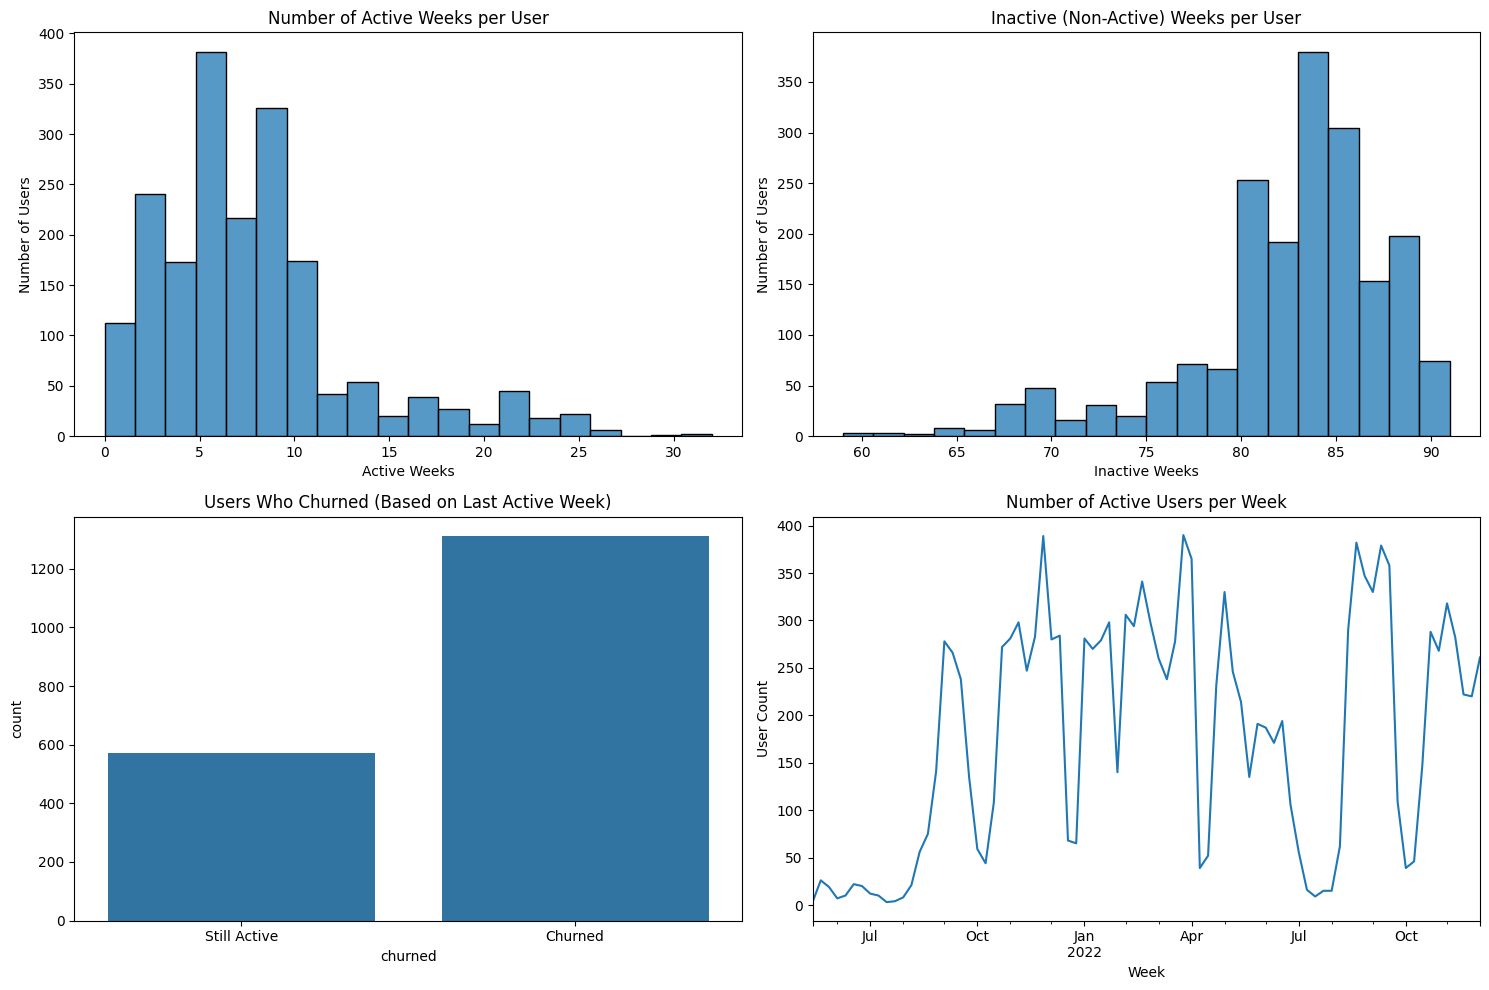

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,weekly_skip_actions,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity,week_start,active_week,next_week_active,week_diff,missing_active_weeks,is_last_week_ever
0,387604,2021-20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107,2021-05-17,0,0,NaN,True,0
1,387604,2021-21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107,2021-05-24,0,0,7.0,True,0
2,387604,2021-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,2021-05-31,0,0,7.0,True,0
3,387604,2021-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,2021-06-07,0,0,7.0,True,0
4,387604,2021-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,2021-06-14,0,1,7.0,True,0


In [11]:
# Plot preparation
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Number of active weeks per user
user_active_counts = df_full.groupby('user_id')['active_week'].sum()
sns.histplot(user_active_counts, bins=20, ax=axs[0, 0])
axs[0, 0].set_title("Number of Active Weeks per User")
axs[0, 0].set_xlabel("Active Weeks")
axs[0, 0].set_ylabel("Number of Users")

# Plot 2: Inactive weeks per user
sns.histplot(user_gaps['missing_active_weeks'], bins=20, ax=axs[0, 1])
axs[0, 1].set_title("Inactive (Non-Active) Weeks per User")
axs[0, 1].set_xlabel("Inactive Weeks")
axs[0, 1].set_ylabel("Number of Users")

# Plot 3: Users who churned based on active behavior
sns.countplot(x='churned', data=user_last_active, ax=axs[1, 0])
axs[1, 0].set_title("Users Who Churned (Based on Last Active Week)")
axs[1, 0].set_xticklabels(['Still Active', 'Churned'])

# Plot 4: Active users per week
weekly_active_user_counts = df_full[df_full['active_week'] == 1].groupby('week_start')['user_id'].nunique()
weekly_active_user_counts.plot(ax=axs[1, 1])
axs[1, 1].set_title("Number of Active Users per Week")
axs[1, 1].set_xlabel("Week")
axs[1, 1].set_ylabel("User Count")

plt.tight_layout()
plt.show()

df_full.head()

In [12]:

df_full[df_full['next_week_active'] == 1].head()

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,weekly_skip_actions,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity,week_start,active_week,next_week_active,week_diff,missing_active_weeks,is_last_week_ever
4,387604,2021-24,0.0,0.0,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,2021-06-14,0,1,7.0,True,0
5,387604,2021-25,7.0,4.0,783722.076,783742.448,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,141.95107,2021-06-21,1,1,7.0,False,0
12,387604,2021-32,12.0,3.0,0.000,0.000,41.000000,0.0,1.0,0.0,0.0,0.0,0.0,141.95107,2021-08-09,0,1,7.0,True,0
14,387604,2021-34,113.0,29.0,0.000,0.000,0.000000,50.0,0.0,0.0,0.0,0.0,0.0,141.95107,2021-08-23,0,1,7.0,True,0
15,387604,2021-35,405.0,111.0,83524.441,6424.957,0.846154,118.0,3.0,0.0,12.0,0.0,0.0,141.95107,2021-08-30,1,1,7.0,False,0


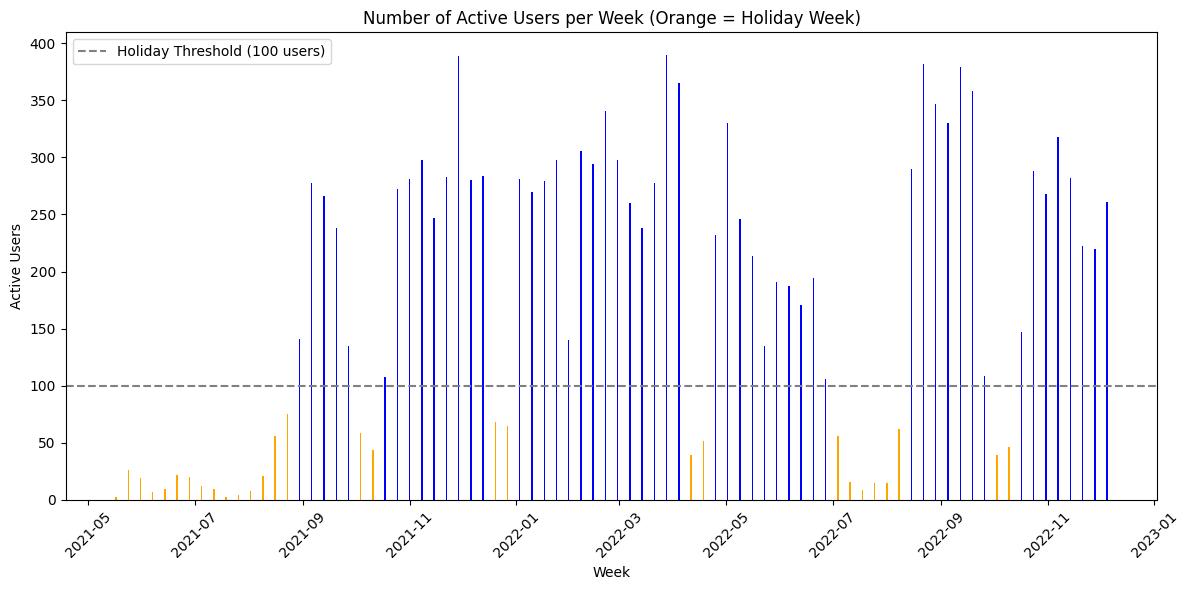

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# STEP 1: Ensure week_start is datetime
df_full['week_start'] = pd.to_datetime(df_full['week_start'])

# STEP 2: Count active users per week
weekly_active = (
    df_full[df_full['active_week'] == 1]
    .groupby('week_start')['user_id']
    .nunique()
    .reset_index(name='active_user_count')
)

# STEP 3: Mark holidays (active user count < 100)
weekly_active['holiday'] = (weekly_active['active_user_count'] < 100).astype(int)

# STEP 4: Merge holiday info back to df_full
df_full = df_full.merge(weekly_active[['week_start', 'holiday']], on='week_start', how='left')

# STEP 5: Drop duplicate holiday columns if they exist
# = df_full.drop(columns=[col for col in df_full.columns if col.startswith('holiday_') and col != 'holiday'])

# STEP 6: Plot active user counts, colored by holiday
colors = weekly_active['holiday'].map({0: 'blue', 1: 'orange'})

plt.figure(figsize=(12, 6))
plt.bar(weekly_active['week_start'], weekly_active['active_user_count'], color=colors)
plt.axhline(100, color='gray', linestyle='--', label='Holiday Threshold (100 users)')
plt.title("Number of Active Users per Week (Orange = Holiday Week)")
plt.xlabel("Week")
plt.ylabel("Active Users")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()




In [14]:
sequence_length = 50

filtered_df = pd.DataFrame()
for user_id, group in df_full.groupby('user_id'):
    group = group.sort_values('week_start')
    first_weeks = group.head(sequence_length)

    if first_weeks['active_week'].sum() > 0:
        filtered_df = pd.concat([filtered_df, group])
filtered_df.head()

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,...,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity,week_start,active_week,next_week_active,week_diff,missing_active_weeks,is_last_week_ever,holiday
0,387604,2021-20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,141.95107,2021-05-17,0,0,NaN,True,0,1
1,387604,2021-21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,141.95107,2021-05-24,0,0,7.0,True,0,1
2,387604,2021-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,2021-05-31,0,0,7.0,True,0,1
3,387604,2021-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,2021-06-07,0,0,7.0,True,0,1
4,387604,2021-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,2021-06-14,0,1,7.0,True,0,1


In [65]:
import pandas as pd
import numpy as np

# STEP 1: Sort your data properly
filtered_df['week_start'] = pd.to_datetime(filtered_df['week_start'])
filtered_df = filtered_df.sort_values(['user_id', 'week_start']).reset_index(drop=True)

# STEP 2: Define columns to use
non_feature_cols = ['user_id', 
                    'week_start',
                    'year_week', 
                    'week_period', 
                    'next_week_active', 
                    'missing_active_weeks', 
                    # 'is_last_week_ever', 
                    'active_week',
                    'week_diff',
                    'weekly_time_spent',
                    'weekly_events',
                    'is_active',
                    'weekly_go_to_theory',
                    'weekly_early_sessions',
                    'weekly_next_actions',
                    'weekly_skip_actions',
                    'weekly_percentage_correct',
                    'weekly_challenges_completed',
                    'std_weekly_activity',
                    # 'mean_session_duration',
                    'mean_days_between_sessions'
                    ]

feature_cols = [col for col in df_full.columns if col not in non_feature_cols]

# STEP 3: Set your sequence length
sequence_length = 3 # You can adjust based on your use case

# STEP 4: Build sequences and labels
X_seq = []
y_seq = []
sequence_users = []

sequence_length = 7  # or any value you choose


for user_id, group in df_full.groupby('user_id'):
    group = group.sort_values('year_week')
    X_user = group[feature_cols].values
    y_user = group['next_week_active'].values  # shape: (n_weeks,)

    for i in range(sequence_length, len(group)):
        X_seq.append(X_user[i - sequence_length:i])
        y_seq.append(y_user[i - sequence_length:i])  # now a sequence of labels
        sequence_users.append(user_id)

X = np.array(X_seq)  # shape: (n_sequences, sequence_length, n_features)
y = np.array(y_seq)  # shape: (n_sequences, sequence_length)
sequence_users = np.array(sequence_users)



In [23]:
print("X_seq[10]:", X_seq[10])  # First sequence
print("y_seq[10]:", y_seq[10])  # First label


X_seq[10]: [[ 0.     0.     0.     1.   ]
 [ 6.     0.     0.     1.   ]
 [ 3.     0.     0.     1.   ]
 [23.     3.437  0.     1.   ]]
y_seq[10]: [0 0 1 0]


In [24]:
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df_full[feature_cols] = scaler.fit_transform(df_full[feature_cols])


In [66]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import numpy as np


non_empty_mask = np.array([np.any(seq) for seq in y_seq])
X_seq = [x for x, keep in zip(X_seq, non_empty_mask) if keep]
y_seq = [y for y, keep in zip(y_seq, non_empty_mask) if keep]
sequence_users = [u for u, keep in zip(sequence_users, non_empty_mask) if keep]

# -------------------------------
# 1. Pad Sequences
# -------------------------------
X = pad_sequences(X_seq, maxlen=sequence_length, dtype='float32', padding='pre')
y = np.array(y_seq)
sequence_users = np.array(sequence_users)

# -------------------------------
# 2. Train/Test Split by User
# -------------------------------
unique_users = np.unique(sequence_users)
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

train_mask = np.isin(sequence_users, train_users)
test_mask = ~train_mask

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Add final axis for LSTM output shape
y_train = y_train[..., np.newaxis]  # shape (N, T, 1)
y_test = y_test[..., np.newaxis]

# -------------------------------
# 3. Compute Class Weights for Sample Weighting
# -------------------------------
flat_y = y_train.ravel()
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(flat_y),
    y=flat_y
)
class_weights = dict(enumerate(weights))  # e.g., {0: 0.5, 1: 2.0}

# Build sample_weight matrix (shape: [n_samples, sequence_length])
sample_weight_train = np.where(y_train.squeeze(-1) == 1,
                               class_weights[1],
                               class_weights[0])

# -------------------------------
# 4. Define LSTM Model
# -------------------------------
model = Sequential([
    Masking(mask_value=0., input_shape=(sequence_length, X.shape[-1])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model.summary()

early_stop = EarlyStopping(
    monitor='val_AUC',       # you’re tracking AUC
    patience=3,              # stop if no improvement for 3 epochs
    mode='max',              # because higher AUC is better
    restore_best_weights=True
)

# -------------------------------
# 5. Train Model with Sample Weights
# -------------------------------
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weight_train,
    epochs=40,
    batch_size=32,
    callbacks=[early_stop]
)

# -------------------------------
# 6. Evaluate
# -------------------------------
loss, auc = model.evaluate(X_test, y_test)
print(f"\n✅ Test AUC: {auc:.3f}")


/Users/tijuana/miniconda3/envs/p311/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_10 (Masking)            │ (None, 7, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 7, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,753 (198.25 KB)

 Trainable params: 50,753 (198.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - AUC: 0.5915 - loss: 0.6532 - val_AUC: 0.6245 - val_loss: 0.6331
Epoch 2/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6184 - loss: 0.6261 - val_AUC: 0.6312 - val_loss: 0.6343
Epoch 3/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6258 - loss: 0.6244 - val_AUC: 0.6345 - val_loss: 0.6209
Epoch 4/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6279 - loss: 0.6186 - val_AUC: 0.6304 - val_loss: 0.6260
Epoch 5/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6293 - loss: 0.6166 - val_AUC: 0.6437 - val_loss: 0.6176
Epoch 6/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6350 - loss: 0.6096 - val_AUC: 0.6426 - val_loss: 0.6429
Epoch 7/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6358 - loss: 0.6115 - val_AUC: 0.6376 - val_loss: 0.6201
Epoch 8/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6350 - loss: 0.6127 - val_AUC: 0.6449 - val_loss: 0.6068
Epoch 9/40
1188/1188 ━━━━━━━━━━━━━━━━━━━

In [67]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score  
from sklearn.metrics import roc_auc_score  

# Predict class probabilities
y_pred_prob = model.predict(X_test)

# Flatten predictions and ground truth
y_pred = (y_pred_prob > 0.48).astype(int).flatten()
y_true = y_test.flatten()

# Print full classification report
print("\n🔍 Classification Report:")
print(classification_report(y_true, y_pred))

# Or extract specific scores
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob.flatten())

print(f"\n✅ Test Accuracy: {accuracy:.3f}")
print(f"\n✅ F1 Score: {f1:.3f}")
print(f"✅ Recall: {recall:.3f}")
print(f"✅ Precision: {precision:.3f}")
print(f"✅ AUC: {auc:.3f}")


308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.42      0.55     48591
           1       0.36      0.78      0.49     20212

    accuracy                           0.52     68803
   macro avg       0.59      0.60      0.52     68803
weighted avg       0.68      0.52      0.54     68803


✅ Test Accuracy: 0.524

✅ F1 Score: 0.489
✅ Recall: 0.776
✅ Precision: 0.357
✅ AUC: 0.651


467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88    393002
           1       0.22      0.28      0.24     54898

    accuracy                           0.79    447900
   macro avg       0.56      0.57      0.56    447900
weighted avg       0.81      0.79      0.80    447900


✅ Test Accuracy: 0.788

✅ F1 Score: 0.244
✅ Recall: 0.279
✅ Precision: 0.216

-> For only clicks with holidays and end activity included 

467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84    393002
           1       0.20      0.39      0.26     54898

    accuracy                           0.73    447900
   macro avg       0.55      0.58      0.55    447900
weighted avg       0.81      0.73      0.77    447900


✅ Test Accuracy: 0.733

✅ F1 Score: 0.262
✅ Recall: 0.385
✅ Precision: 0.198

-> 



623/623 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_33 (Masking)            │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 30, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90    531902
           1       0.33      0.50      0.40     65818

    accuracy                           0.83    597720
   macro avg       0.63      0.69      0.65    597720
weighted avg       0.87      0.83      0.85    597720


✅ Test Accuracy: 0.834

✅ F1 Score: 0.398
✅ Recall: 0.498
✅ Precision: 0.331


---> on number of clicks and last seen user and holidays 

623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90    531902
           1       0.34      0.53      0.41     65818

    accuracy                           0.83    597720
   macro avg       0.64      0.70      0.66    597720
weighted avg       0.87      0.83      0.85    597720


✅ Test Accuracy: 0.834

✅ F1 Score: 0.412
✅ Recall: 0.529
✅ Precision: 0.337


length 30 
623/623 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91    531902
           1       0.34      0.49      0.40     65818

    accuracy                           0.84    597720
   macro avg       0.64      0.69      0.65    597720
weighted avg       0.87      0.84      0.85    597720


✅ Test Accuracy: 0.839

✅ F1 Score: 0.401
✅ Recall: 0.491
✅ Precision: 0.339

seq length 4 filtered for empty seq

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.40      0.51     17487
           1       0.46      0.74      0.57     11885

    accuracy                           0.54     29372
   macro avg       0.58      0.57      0.54     29372
weighted avg       0.60      0.54      0.54     29372


✅ Test Accuracy: 0.543

✅ F1 Score: 0.569
✅ Recall: 0.745
✅ Precision: 0.460
✅ AUC: 0.611

n= 30 filtered for empty seq

458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89    373613
           1       0.37      0.38      0.37     66037

    accuracy                           0.81    439650
   macro avg       0.63      0.63      0.63    439650
weighted avg       0.81      0.81      0.81    439650


✅ Test Accuracy: 0.809

✅ F1 Score: 0.373
✅ Recall: 0.377
✅ Precision: 0.369
✅ AUC: 0.750

n = 10 filtered for empty seq

63/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.85     87858
           1       0.44      0.20      0.28     28082

    accuracy                           0.75    115940
   macro avg       0.61      0.56      0.56    115940
weighted avg       0.70      0.75      0.71    115940


✅ Test Accuracy: 0.745

✅ F1 Score: 0.279
✅ Recall: 0.204
✅ Precision: 0.443
✅ AUC: 0.678

n = 2 filtered for empty seq

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      3589
           1       0.70      0.73      0.72      6047

    accuracy                           0.64      9636
   macro avg       0.61      0.61      0.61      9636
weighted avg       0.63      0.64      0.64      9636


✅ Test Accuracy: 0.637

✅ F1 Score: 0.715
✅ Recall: 0.726
✅ Precision: 0.705
✅ AUC: 0.638

n = 3 filtered for empty seq
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.42      0.51      9657
           1       0.55      0.76      0.64      8988

    accuracy                           0.58     18645
   macro avg       0.60      0.59      0.57     18645
weighted avg       0.60      0.58      0.57     18645


✅ Test Accuracy: 0.583

✅ F1 Score: 0.636
✅ Recall: 0.756
✅ Precision: 0.549
✅ AUC: 0.620

n = 4 filtered for empty seq

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.38      0.50     17487
           1       0.46      0.77      0.57     11885

    accuracy                           0.54     29372
   macro avg       0.58      0.57      0.53     29372
weighted avg       0.61      0.54      0.53     29372


✅ Test Accuracy: 0.538

✅ F1 Score: 0.574
✅ Recall: 0.768
✅ Precision: 0.458
✅ AUC: 0.614

n = 5 filtered for empty seq

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.38      0.50     17487
           1       0.46      0.77      0.57     11885

    accuracy                           0.54     29372
   macro avg       0.58      0.57      0.53     29372
weighted avg       0.61      0.54      0.53     29372


✅ Test Accuracy: 0.538

✅ F1 Score: 0.574
✅ Recall: 0.768
✅ Precision: 0.458
✅ AUC: 0.614

n = 6 filtered for empty seq

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.40      0.53     37150
           1       0.38      0.77      0.51     17498

    accuracy                           0.52     54648
   macro avg       0.58      0.59      0.52     54648
weighted avg       0.66      0.52      0.52     54648


✅ Test Accuracy: 0.518

✅ F1 Score: 0.506
✅ Recall: 0.771
✅ Precision: 0.377
✅ AUC: 0.632

n= 7 filtered for empty seq

308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.42      0.55     48591
           1       0.36      0.78      0.49     20212

    accuracy                           0.52     68803
   macro avg       0.59      0.60      0.52     68803
weighted avg       0.68      0.52      0.54     68803


✅ Test Accuracy: 0.524

✅ F1 Score: 0.489
✅ Recall: 0.776
✅ Precision: 0.357
✅ AUC: 0.651

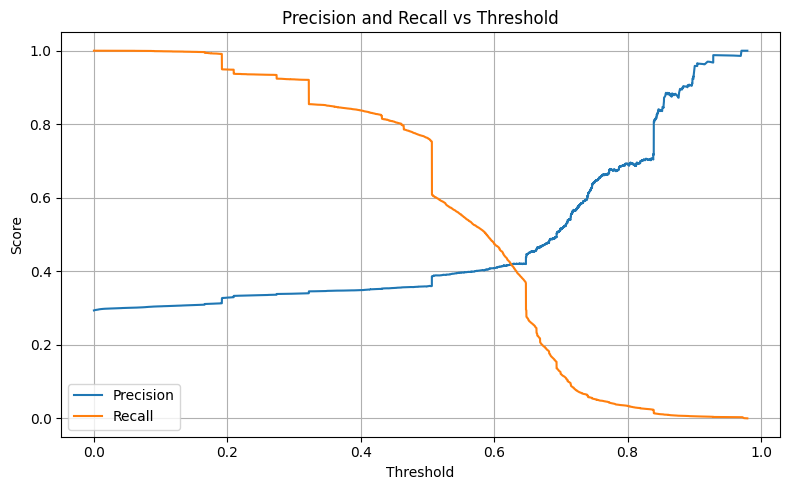

In [68]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Flatten predictions and labels
y_pred_prob_flat = y_pred_prob.flatten()
y_test_flat = y_test.flatten()

# Compute precision-recall curve
prec, rec, thresholds = precision_recall_curve(y_test_flat, y_pred_prob_flat)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, prec[:-1], label='Precision')
plt.plot(thresholds, rec[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision and Recall vs Threshold")
plt.grid(True)
plt.tight_layout()
plt.show()


This is our model with  

### 1. visualize the features and clusters with in this idea of plots (output similarities)
### 2. think about creating a label with last seen and then predict output 
### 3. redo models with lstm and gru to see if they are better than the previous ones
###

# Vizualize the features and clusters with in this idea of plots (output similarities)

In [21]:
# Create a copy of the original dataframe
df_full = df.copy()

# Extract basic info
n_users = df_full['user_id'].nunique()

# Group data per user and count number of weeks and gaps
df_full = df_full.sort_values(by=['user_id', 'week_start'])
df_full['week_diff'] = df_full.groupby('user_id')['week_start'].diff().dt.days

# Identify missing weeks (difference greater than 7 days)
df_full['missing_weeks'] = df_full['week_diff'].apply(lambda x: 1 if x is not None and x > 7 else 0)
user_gaps = df_full.groupby('user_id')['missing_weeks'].sum().reset_index()

# Determine if users have "churned" (i.e., never come back after their last record)
last_week = df_full['week_start'].max()
user_last_seen = df_full.groupby('user_id')['week_start'].max().reset_index()
user_last_seen['churned'] = user_last_seen['week_start'] < last_week

# Count churned users
churned_users = user_last_seen['churned'].sum()

# Prepare plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Number of records per user
user_activity_counts = df_full.groupby('user_id').size()
sns.histplot(user_activity_counts, bins=20, ax=axs[0, 0])
axs[0, 0].set_title("Number of Weeks per User")
axs[0, 0].set_xlabel("Weeks Logged")
axs[0, 0].set_ylabel("Number of Users")

# Plot 2: Missing weeks per user
sns.histplot(user_gaps['missing_weeks'], bins=20, ax=axs[0, 1])
axs[0, 1].set_title("Missing Weeks per User")
axs[0, 1].set_xlabel("Missing Week Gaps")
axs[0, 1].set_ylabel("Number of Users")

# Plot 3: Users who churned vs. not
sns.countplot(x='churned', data=user_last_seen, ax=axs[1, 0])
axs[1, 0].set_title("Users Who Churned (Never Returned)")
axs[1, 0].set_xticklabels(['Still Active', 'Churned'])

# Plot 4: Timeline of weekly data completeness
weekly_user_counts = df_full.groupby('week_start')['user_id'].nunique()
weekly_user_counts.plot(ax=axs[1, 1])
axs[1, 1].set_title("Number of Active Users per Week")
axs[1, 1].set_xlabel("Week")
axs[1, 1].set_ylabel("User Count")

plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

Here in plot number of active users per week we can clearly identify the holidays swiss schools have. This can possibly confuse our model. We have to see how to adress this issue. 

additional research question:
* How can we measure the retention of pupils on the platform?
* Can we identify the holidays in the data?
* Based on the data, can we identify if a pupil will have holidays next week? 

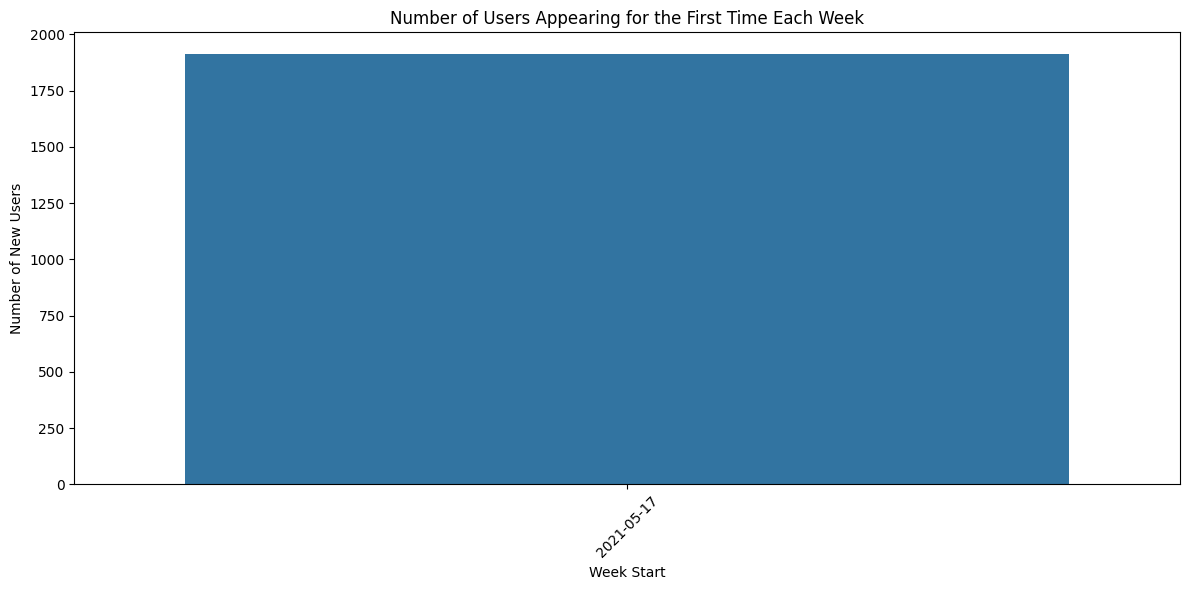

In [ ]:
# Identify the first week each user appears in the data
first_week_per_user = df_full.groupby("user_id")["week_start"].min().reset_index()
first_week_distribution = first_week_per_user["week_start"].value_counts().sort_index()

# Plot the distribution of new users over time
plt.figure(figsize=(12, 6))
sns.barplot(x=first_week_distribution.index, y=first_week_distribution.values)
plt.xticks(rotation=45)
plt.title("Number of Users Appearing for the First Time Each Week")
plt.xlabel("Week Start")
plt.ylabel("Number of New Users")
plt.tight_layout()
plt.show()


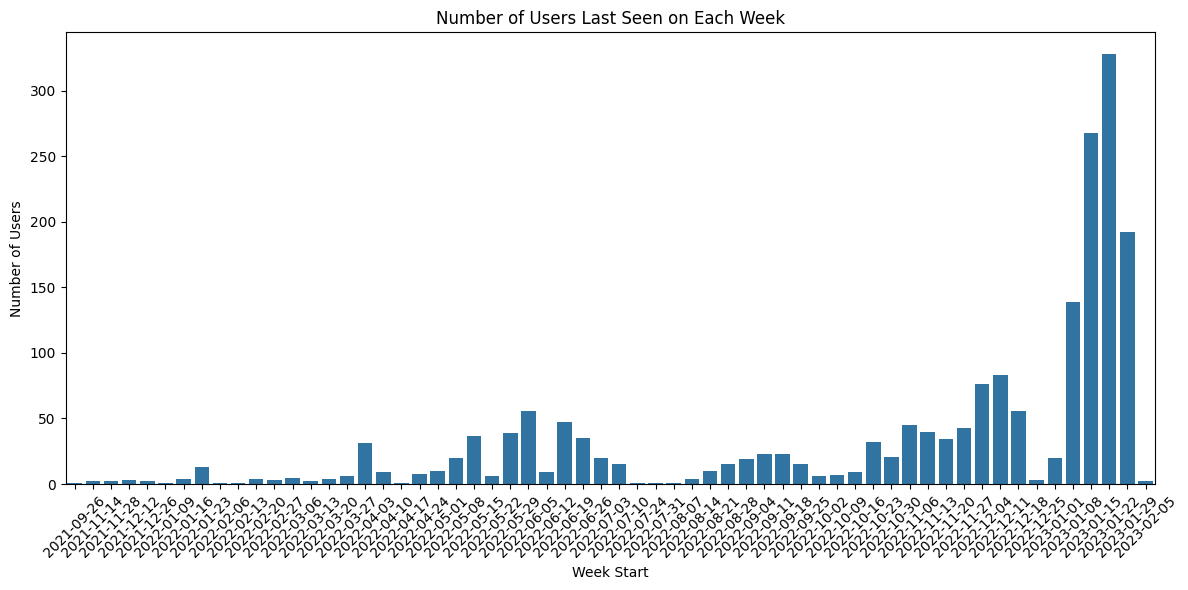

In [ ]:
# Get the last active week for each user
last_week_per_user = df_full.groupby("user_id")["week_start"].max().reset_index()
last_week_distribution = last_week_per_user["week_start"].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=last_week_distribution.index, y=last_week_distribution.values)
plt.xticks(rotation=45)
plt.title("Number of Users Last Seen on Each Week")
plt.xlabel("Week Start")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()


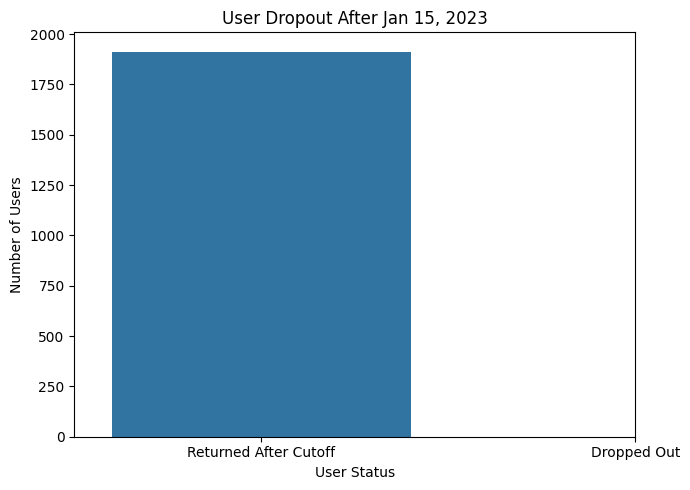

In [ ]:
# create a survival analysis for forever dropouts 

from datetime import datetime

# Filter data to stop records mid-Jan 2023 for survival analysis
cutoff_date = datetime(2022, 10, 15)
df_cutoff = df_full[df_full['week_start'] <= cutoff_date]

# Identify last seen date for each user before the cutoff
last_seen_cutoff = df_cutoff.groupby('user_id')['week_start'].max().reset_index()
last_seen_cutoff.columns = ['user_id', 'last_seen_before_cutoff']

# Count how many were never seen again after cutoff
after_cutoff = df_full[df_full['week_start'] > cutoff_date]
reappeared_users = after_cutoff['user_id'].unique()
last_seen_cutoff['churned_after_cutoff'] = ~last_seen_cutoff['user_id'].isin(reappeared_users)

# Count churners vs. returners
churn_summary = last_seen_cutoff['churned_after_cutoff'].value_counts()

# Plot the updated churn info
plt.figure(figsize=(7, 5))
sns.countplot(x='churned_after_cutoff', data=last_seen_cutoff)
plt.xticks([0, 1], ['Returned After Cutoff', 'Dropped Out'])
plt.title("User Dropout After Jan 15, 2023")
plt.xlabel("User Status")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()


First plots how many new users when the school year starts.

second plots looses many users when the school year end or the exam finished. 

it would be useful to have a longer time series 

In [ ]:

# ADD missing weeks

# Example structure if data is reloaded; simulate minimal version
# df_full = pd.read_csv("your_data.csv")  # Assuming df_full already exists

df_full['week_start'] = pd.to_datetime(df_full['week_start'])

# Step 2: Create full grid of user-week combinations
all_weeks = pd.date_range(start=df_full['week_start'].min(), end=df_full['week_start'].max(), freq='W-SUN')
all_user_weeks = pd.MultiIndex.from_product(
    [df_full['user_id'].unique(), all_weeks],
    names=["user_id", "week_start"]
).to_frame(index=False)

# Step 3: Merge with original data only where the (user, week) pair is missing
existing = df
missing_pairs = pd.merge(all_user_weeks, existing, on=['user_id', 'week_start'], how='left', indicator=True)
missing_only = missing_pairs[missing_pairs['_merge'] == 'left_only'].drop(columns=['_merge'])

# Step 4: Fill missing rows with zeros for all non-key columns
filled_rows = pd.DataFrame(0, index=missing_only.index, columns=[col for col in df_full.columns if col not in ['user_id', 'week_start']])
filled_rows['user_id'] = missing_only['user_id'].values
filled_rows['week_start'] = missing_only['week_start'].values

# Step 5: Combine and sort
df_combined = pd.concat([df_full, filled_rows], ignore_index=True)
df_combined = df_combined.sort_values(by=['user_id', 'week_start']).reset_index(drop=True)

df_combined.head()
#df_combined.head()








,user_id,week_start,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,weekly_skip_actions,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity,week_period,engaged_next_week,week_diff,missing_weeks
0,387604,2021-05-16,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,NaN,0
1,387604,2021-05-16,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
2,387604,2021-05-23,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,7.0,0
3,387604,2021-05-23,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
4,387604,2021-05-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,7.0,0


/var/folders/0k/43ckgrhd7cd68vbpqrmw9r240000gn/T/ipykernel_2202/2235195231.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(['Still Active', 'Churned'])


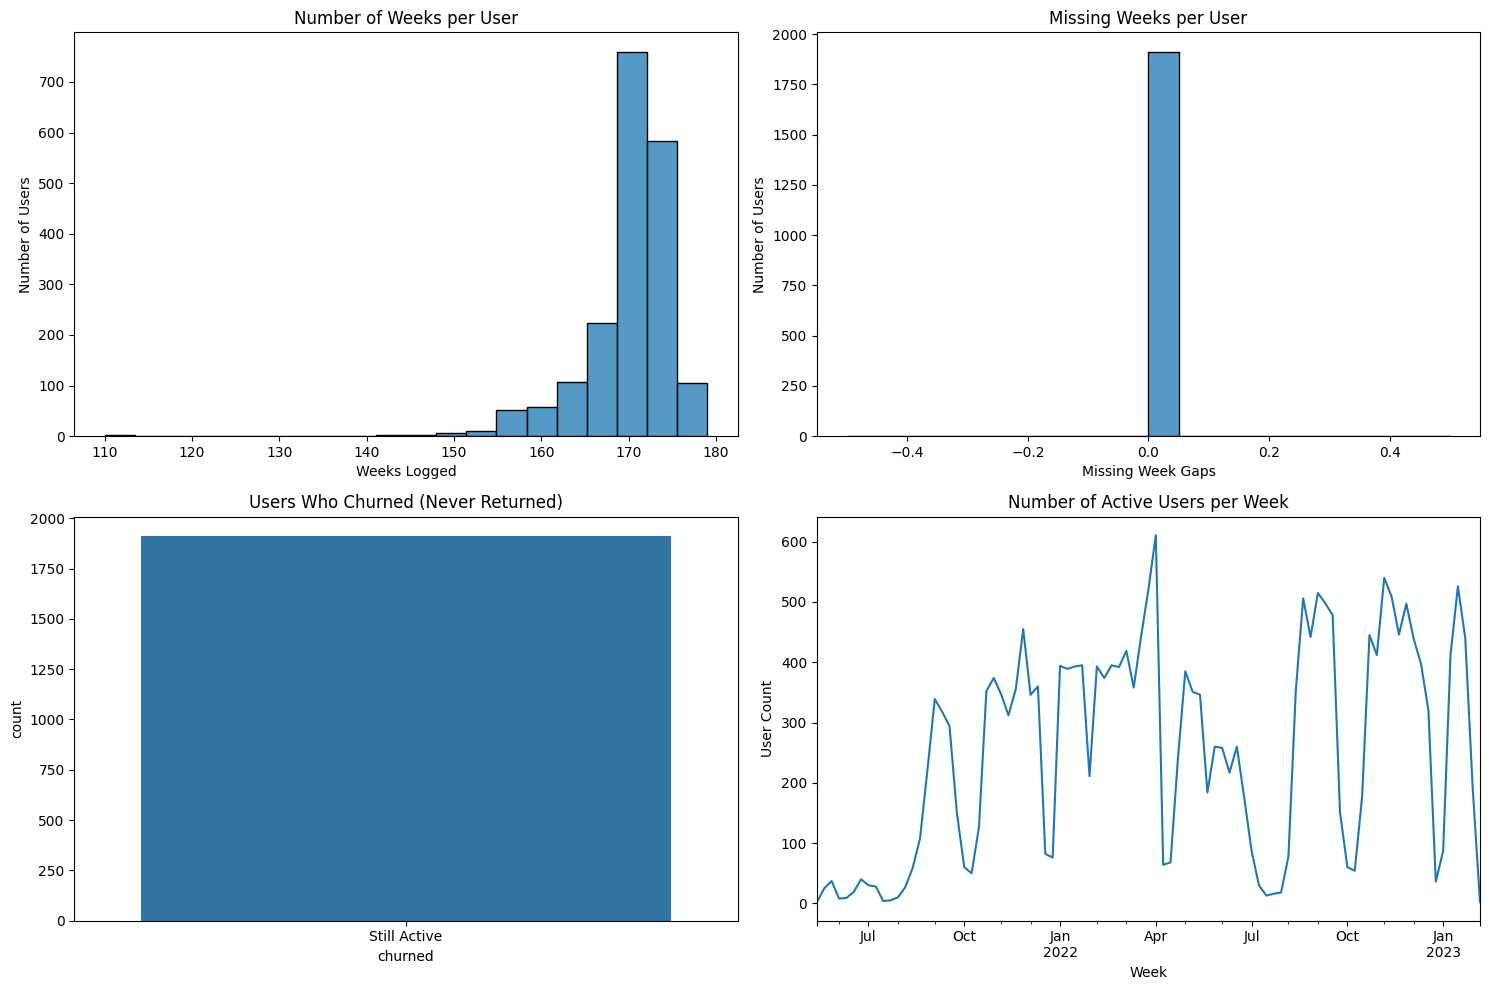

In [ ]:
# Create a copy of the original dataframe
df_full = df_combined.copy()

# Extract basic info
n_users = df_full['user_id'].nunique()

# Group data per user and count number of weeks and gaps
df_full = df_full.sort_values(by=['user_id', 'week_start'])
df_full['week_diff'] = df_full.groupby('user_id')['week_start'].diff().dt.days

# Identify missing weeks (difference greater than 7 days)
df_full['missing_weeks'] = df_full['week_diff'].apply(lambda x: 1 if x is not None and x > 7 else 0)
user_gaps = df_full.groupby('user_id')['missing_weeks'].sum().reset_index()

# Determine if users have "churned" (i.e., never come back after their last record)
last_week = df_full['week_start'].max()
user_last_seen = df_full.groupby('user_id')['week_start'].max().reset_index()
user_last_seen['churned'] = user_last_seen['week_start'] < last_week

# Count churned users
churned_users = user_last_seen['churned'].sum()

# Prepare plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Number of records per user
user_activity_counts = df_full.groupby('user_id').size()
sns.histplot(user_activity_counts, bins=20, ax=axs[0, 0])
axs[0, 0].set_title("Number of Weeks per User")
axs[0, 0].set_xlabel("Weeks Logged")
axs[0, 0].set_ylabel("Number of Users")

# Plot 2: Missing weeks per user
sns.histplot(user_gaps['missing_weeks'], bins=20, ax=axs[0, 1])
axs[0, 1].set_title("Missing Weeks per User")
axs[0, 1].set_xlabel("Missing Week Gaps")
axs[0, 1].set_ylabel("Number of Users")

# Plot 3: Users who churned vs. not
sns.countplot(x='churned', data=user_last_seen, ax=axs[1, 0])
axs[1, 0].set_title("Users Who Churned (Never Returned)")
axs[1, 0].set_xticklabels(['Still Active', 'Churned'])

# Plot 4: Timeline of weekly data completeness
weekly_user_counts = df_full[df_full['weekly_events'] > 0].groupby('week_start')['user_id'].nunique()
weekly_user_counts.plot(ax=axs[1, 1])
axs[1, 1].set_title("Number of Active Users per Week")
axs[1, 1].set_xlabel("Week")
axs[1, 1].set_ylabel("User Count")

plt.tight_layout()
plt.show()


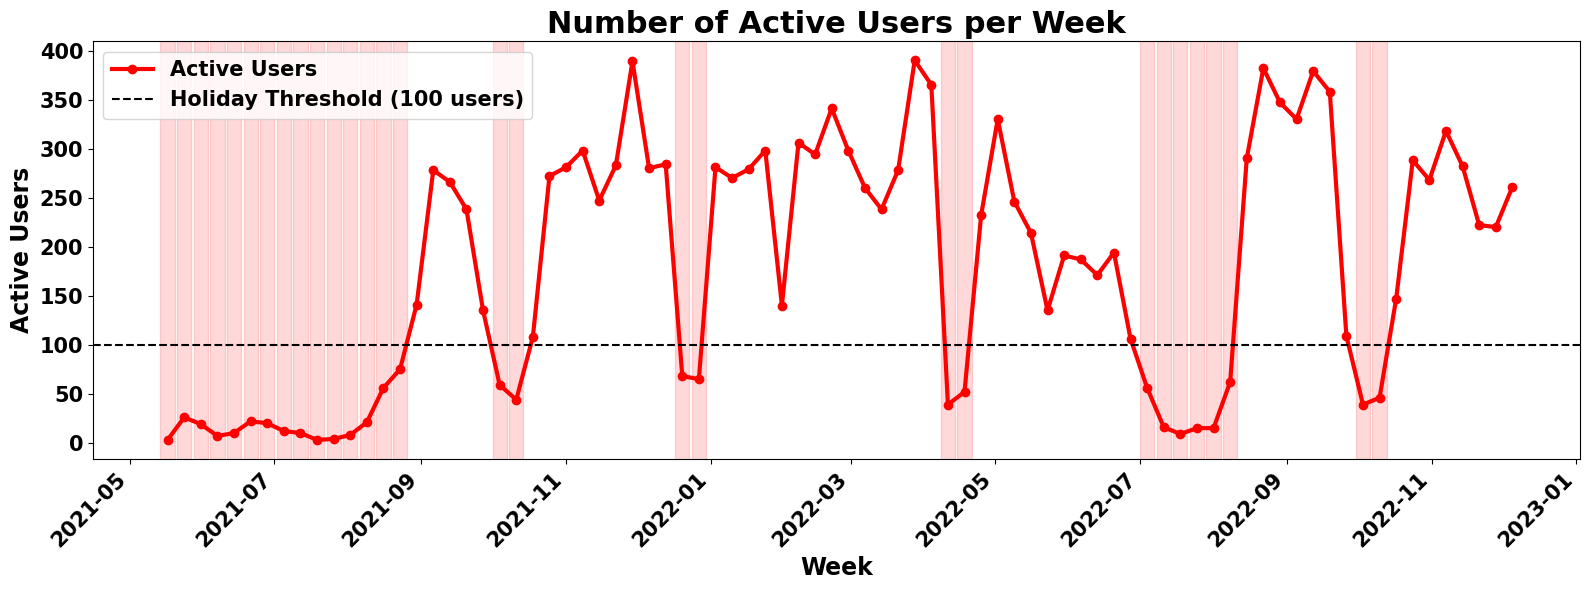

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Updated plot with bold, larger fonts and proper right alignment
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(
    weekly_active['week_start'],
    weekly_active['active_user_count'],
    color='red',
    linewidth=3,
    marker='o',
    label='Active Users',
)

# Highlight holiday periods
for i, row in weekly_active.iterrows():
    if row['holiday'] == 1:
        ax.axvspan(row['week_start'] - pd.Timedelta(days=3),
                   row['week_start'] + pd.Timedelta(days=3),
                   color='red', alpha=0.15)

ax.axhline(100, color='black', linestyle='--', label='Holiday Threshold (100 users)')

# Title and axis labels styling
ax.set_title("Number of Active Users per Week", fontsize=22, fontweight='bold')
ax.set_xlabel("Week", fontsize=17, fontweight='bold')
ax.set_ylabel("Active Users", fontsize=17, fontweight='bold')


# Ticks formatting
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')
    label.set_fontsize(15)
    label.set_fontweight('bold')

for label in ax.get_yticklabels():
    label.set_fontsize(15)
    label.set_fontweight('bold')

# Legend
ax.legend(loc='upper left', prop={'weight': 'bold', 'size': 15})
# Layout and save
plt.tight_layout()
plot_path = "holiday_engagement_plot_bold_aligned.png"
plt.savefig(plot_path, dpi=300)
plt.show()
